* Profesor: Eduardo Sánchez Burillo
* Contacto: eduardo.sanchez@predictland.com

In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.9 MB/s eta 0:00:00


In [2]:
# Importamos los módulos de Python que utilizaremos
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
warnings.filterwarnings('ignore')

# Introducción
A lo largo de este documento, vamos a tomar el caso de uso que visteis en la demo de introducción al aprendizaje automático, el de los accidentes cerebrovasculares, y vamos a construir modelos de clasificación. En particular, usaremos:
* Árbol de decisión
* Random Forest
* XGBoost
* Regresión logística
* SVM

La estructura del documento es la siguiente:

1. Introducción
2. Caso de uso
3. Modelos triviales
4. Árbol de decisión
5. Random Forest
6. XGBoost
7. Regresión logística
8. SVM
9. Comparación entre modelos

# Caso de uso

Como decíamos, considerarmos un conjunto de datos de accidentes cerebrovasculares obtenido en Kaggle:

* Enlace: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
* Autor: https://www.kaggle.com/fedesoriano

In [3]:
os.getcwd()
os.chdir('/content/sample_data')

In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

Prescindimos del análisis exploratorio que visteis en el módulo de introducción, excepto del de la variable objetivo, ya que conviene refrescar ciertos conceptos.

## Variable objetivo
Analizamos la variable objetivo "stroke". Empezaremos por analizar la variable en sí, para luego ver cómo se relaciona con nuestras variables independientes.

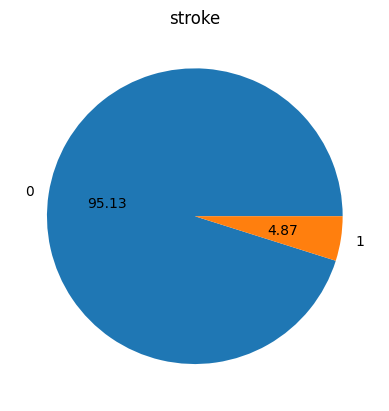

In [ ]:
df["stroke"].value_counts().rename("").plot.pie(autopct='%.2f', title="stroke");

Tenemos pues un problema de clasificación claramente desequilibrado: una de las clases (0) es mucho más frecuente que la otra (1). Esto da más importancia al hecho de que no solo debamos fijarnos en la *accuracy*, sino también en el *recall* y la *precision*. Si bien vimos tales conceptos en la parte de clasificación, recordemos aquí lo que son:
$$
\begin{align}
&\text{Recall} = \frac{TP}{TP+FN},\\
&\text{Precision} = \frac{TP}{TP+FP}.
\end{align}
$$

Cuál de las dos consideramos, si "recall" o "precision", depende del problema. Podríamos pensar que, a priori, tiene más sentido minimizar los falsos negativos o, lo que es lo mismo, maximizar el *recall*. La idea es que no nos gustaría tener gente con un alto riesgo de accidente cerebrovascular a la que se diagnostique como sana, teniendo en cuenta que las consecuencias de estos problemas pueden ser fatales. Sin embargo, también puede darse el caso de que el tratamiento con el que haya que tratar a las personas diagnosticadas tenga graves efectos secundarios, de tal forma que solo compensa aplicarlo si tenemos una cierta certeza de que la persona va a desarrollar este problema; dicho de otro modo, querríamos entonces minimizar los falsos positivos o maximizar la *precision*.

Una forma de tener en cuenta ambas cantidades a la vez es considerar lo que se conoce como *F1-score*:

$$
\text{F1-score}= 2\;\frac{\text{Recall}\cdot\text{Precision}}{\text{Recall} + \text{Precision}}
$$

Aquí usaremos esta cantidad.

Decir que esta magnitud tiene en cuenta por igual *recall* y *precision*. Supongamos que estamos desarrollando esto con un equipo de un hospital y nos dicen que, si bien es correcto tener en cuenta ambas magnitudes, tiene más sentido darle más peso al *recall*. En tal caso, podríamos utilizar el *F$\beta$-score*:

$$
\text{F}\beta\text{-score}= (1+\beta^2)\;\frac{\text{Recall}\cdot\text{Precision}}{\text{Recall} + \beta^2\;\text{Precision}}
$$

También podemos estudiar la correlación entre la variable objetivo y las distintas variables. Empezamos por las numéricas. Mostramos la probabilidad de presentar accidente cerebrovascular ("stroke") como función de nuestras variables numéricas:

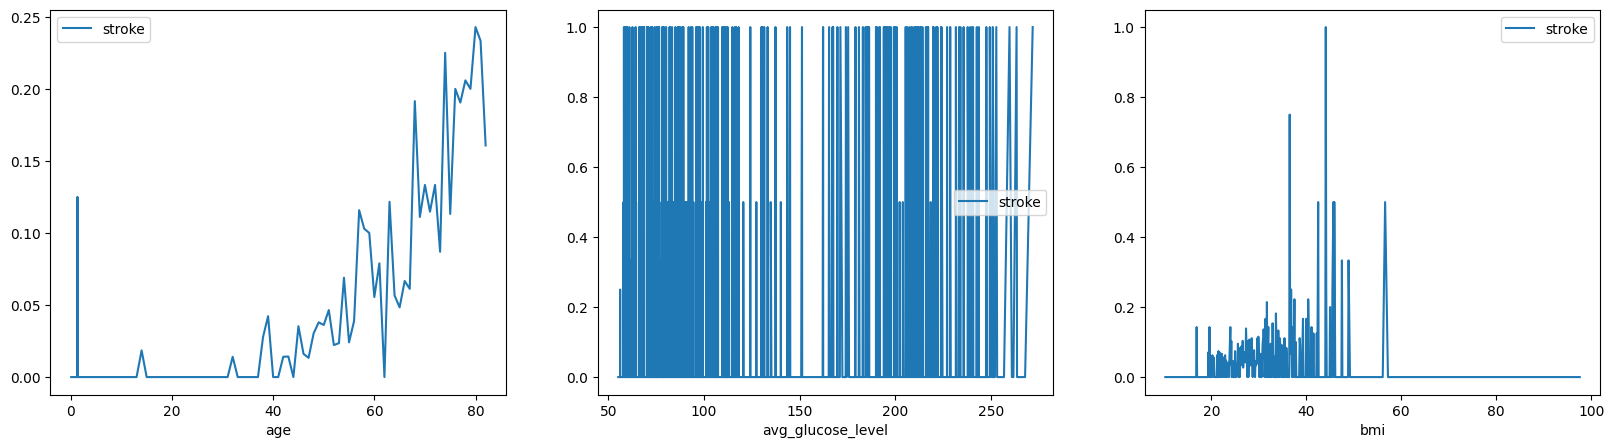

In [6]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
df[["age", "stroke"]].groupby(by="age").mean().plot(ax=axes[0]);
df[["avg_glucose_level", "stroke"]].groupby(by="avg_glucose_level").mean().plot(ax=axes[1]);
df[["bmi", "stroke"]].groupby(by="bmi").mean().plot(ax=axes[2]);

A priori, parece claro que a más "age", más probabilidad de "stroke". Del mismo modo, también se aprecia una tendencia típicamente al alza entre "bmi" y "stroke", excepto para valores de "bmi" muy altos. Finalmente, vemos una densidad bastante alta de "stroke" para valores altos o bajos de "avg_glucose_level", mientras que para valores intermedios (en torno a 150) apenas se aprecian accidentes cerebrovasculares.

En resumidas cuentas, las tres variables muestran relación con la variable objetivo, así que deberíamos tenerlas en cuenta.

Vayamos ahora con la relación con las categóricas, mostrando cuál es la probabilidad de presentar "stroke" para cada una de las categorías:

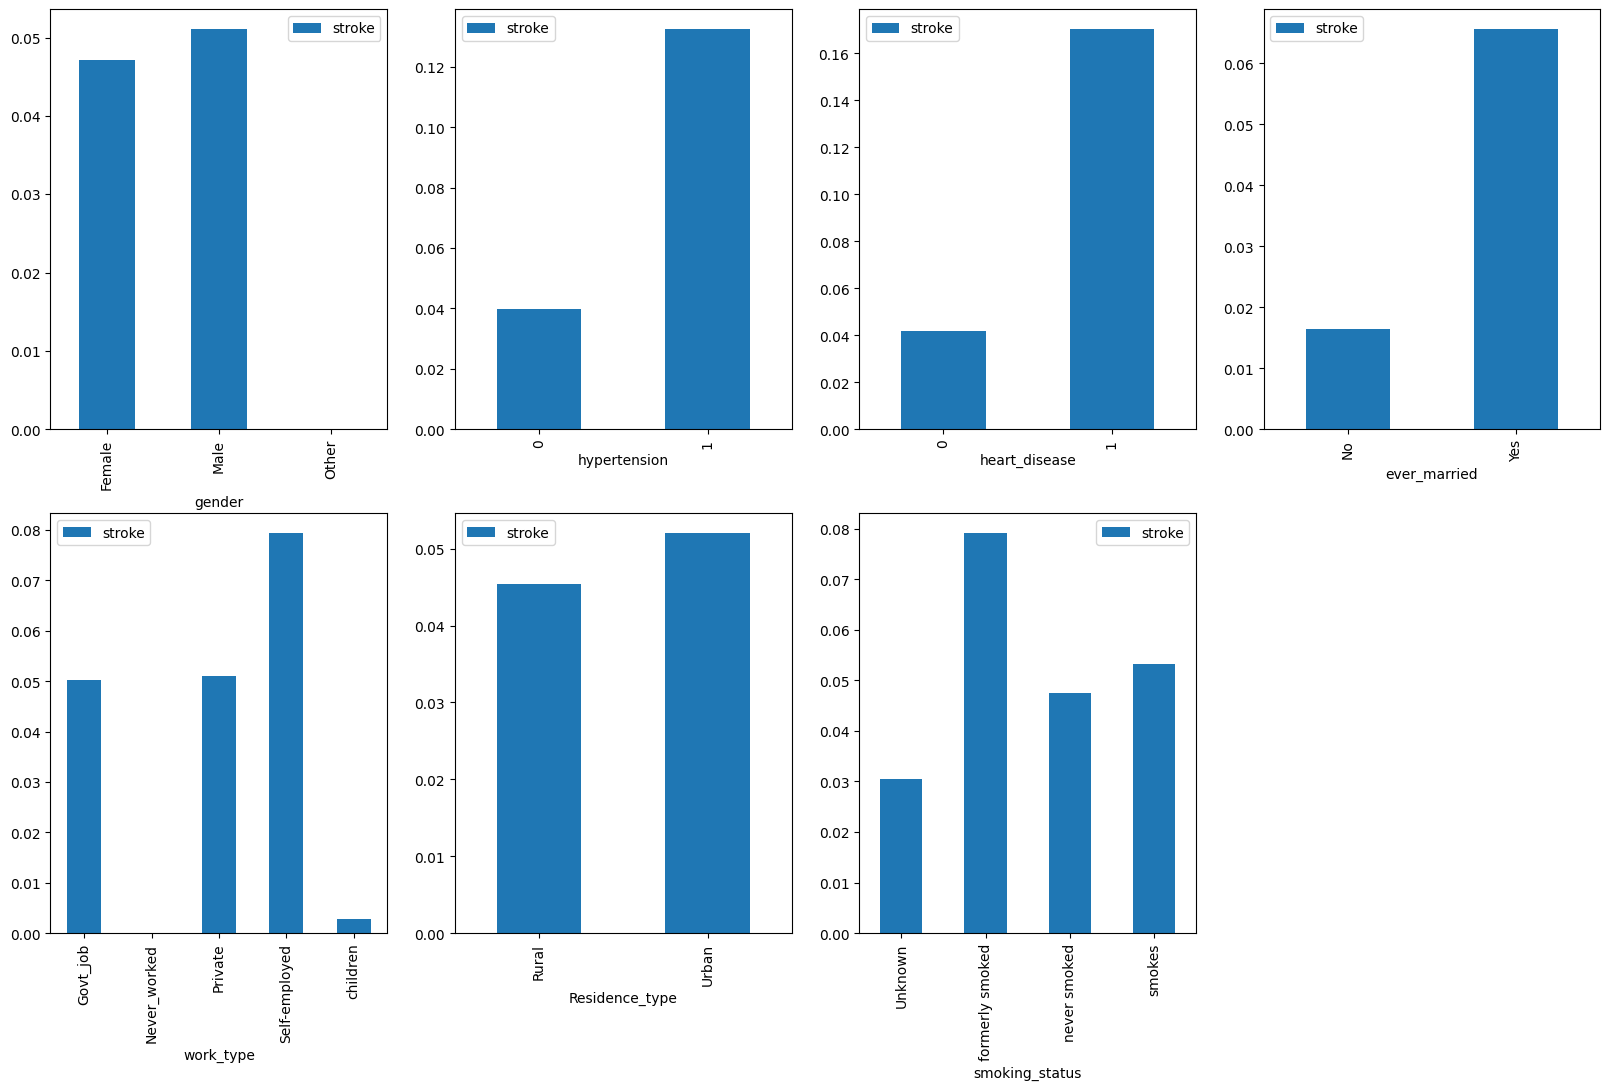

In [ ]:
fig, axes = plt.subplots(2, 4)
axes[-1, -1].axis('off')
fig.set_size_inches(20, 12)
df[["gender", "stroke"]].groupby(by="gender").mean().plot(kind="bar", ax=axes[0,0]);
df[["hypertension", "stroke"]].groupby(by="hypertension").mean().plot(kind="bar", ax=axes[0,1]);
df[["heart_disease", "stroke"]].groupby(by="heart_disease").mean().plot(kind="bar", ax=axes[0,2]);
df[["ever_married", "stroke"]].groupby(by="ever_married").mean().plot(kind="bar", ax=axes[0,3]);
df[["work_type", "stroke"]].groupby(by="work_type").mean().plot(kind="bar", ax=axes[1,0]);
df[["Residence_type", "stroke"]].groupby(by="Residence_type").mean().plot(kind="bar", ax=axes[1,1]);
df[["smoking_status", "stroke"]].groupby(by="smoking_status").mean().plot(kind="bar", ax=axes[1,2]);

Como vemos, varias de las variables parecen no afectar nada a la tasa de accidentes cerebrovasculares. En concreto:
* "gender"
* "Residence_type"

Por tanto, puede ser interesante prescindir de ellas para un primer modelo. Por otra parte, las variables:
* "work_type"
* "smoking_status"

parecen tener una correlación bastante débil con nuestra variable objetivo, por lo que también podríamos deshacernos de ellas. Se podría argumentar que las categorías "Never_worked" y "children" de "work_type" sí que correlacionan, pero:
* Como hemos visto, "Never_worked" es una categoría con demasiada poca estadística como para sacar conclusiones de ella.
* Si una persona cae en la categoría "children" ya está recogido en la edad, así que, en principio, esta información ya la tenemos en la variable "age".

Finalmente, las variables:
* "hypertension"
* "heart_disease"
* "ever_married"

aparentan tener una fuerte correlación con la variable objetivo.

## Separación en entrenamiento y test
Separamos en entrenamiento y test, como visteis en la parte de introducción:

In [7]:
X = df.drop(columns=["id", "stroke"], inplace=False)
y = df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Separamos solo en entrenamiento y test, pero haremos validación cruzada sobre nuestro conjunto de entrenamiento X_train.

## Limpieza de datos
Sustituimos los valores ausentes de "bmi" por su mediana:

In [8]:
list_numerical_variables = ["age", "avg_glucose_level", "bmi"]
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train[list_numerical_variables])

array_X_train_numerical= imp_median.transform(X_train[list_numerical_variables])
X_train[list_numerical_variables] = pd.DataFrame(array_X_train_numerical, columns=list_numerical_variables, index=X_train.index)

array_X_test_numerical= imp_median.transform(X_test[list_numerical_variables])
X_test[list_numerical_variables] = pd.DataFrame(array_X_test_numerical, columns=list_numerical_variables, index=X_test.index)

## Ingeniería de variables

Repetimos la ingeniería de variables que visteis en el módulo de introducción.

### Variables numéricas

#### "bmi": categorización

In [9]:
def introduce_bmi_status(X):
    X["bmi_status"] = ""
    X.bmi_status.loc[X.bmi < 18.5] = "underweight"
    X.bmi_status.loc[(X.bmi >= 18.5) & (X.bmi < 25)] = "normal"
    X.bmi_status.loc[(X.bmi >= 25) & (X.bmi < 30)] = "overweight"
    X.bmi_status.loc[(X.bmi >= 30)] = "obesity"
    return X

X_train = introduce_bmi_status(X_train)
X_test = introduce_bmi_status(X_test)

#### "age": *binning*

In [10]:
# Esta transformación, puesto que no hace uso de información sensible de leakage, se aplica por igual a train y a test.
X_train['age_group'], X_test['age_group'] = 0, 0

X_train.loc[X_train['age'].between(15, 23), ['age_group']] = 1
X_test.loc[X_test['age'].between(15, 23), ['age_group']] = 1

X_train.loc[X_train['age'].between(23, 33), ['age_group']] = 2
X_test.loc[X_test['age'].between(23, 33), ['age_group']] = 2

X_train.loc[X_train['age'].between(33, 65), ['age_group']] = 3
X_test.loc[X_test['age'].between(33, 65), ['age_group']] = 3

X_train.loc[X_train['age']>=65, ['age_group']] = 4
X_test.loc[X_test['age']>=65, ['age_group']] = 4

#### "age": agrupación uniforme

In [11]:
_, bins = pd.qcut(X_train.age, q=5, retbins=True)
bins = np.concatenate(([0], bins[1:-1], [np.inf]))

X_train['age_group_unif'] = pd.cut(X_train.age, bins)
X_test['age_group_unif'] = pd.cut(X_test.age, bins)

#### "avg_glucose_level": *binning*

In [12]:
float_glucose_min = X_train.avg_glucose_level.min()
float_glucose_max = X_train.avg_glucose_level.max()
int_bins = 40
array_bins = float_glucose_min + np.r_[0:int_bins + 1] * (float_glucose_max - float_glucose_min) / int_bins

X_avg_glucose_level = pd.cut(x=X_train.avg_glucose_level, bins=100, labels=range(100))

In [13]:
def find_bin(x, array_bins):
    bool_larger = x > array_bins
    if bool_larger.any():
        return np.where(bool_larger)[0].max()
    else:
        return -1

X_train["avg_glucose_level_binned"] = X_train.avg_glucose_level.apply(find_bin, args=(array_bins,)).rename("avg_glucose_level_binned")
X_test["avg_glucose_level_binned"] = X_test.avg_glucose_level.apply(find_bin, args=(array_bins,)).rename("avg_glucose_level_binned")

#### Escalado y normalización

In [14]:
# Importamos la clase
from sklearn.preprocessing import MinMaxScaler

# Instanciamos el Scaler
mm = MinMaxScaler()

# Transformamos
X_train_sc0 = X_train[['age', 'avg_glucose_level', 'bmi']].copy()
X_test_sc0 = X_test[['age', 'avg_glucose_level', 'bmi']].copy()

# Entrenamos el Scaler sobre el conjunto de entrenamiento
mm.fit(X_train_sc0)

# El objeto 'mm' almacena los valores máximos y mínimos para hacer la transformación
X_min0 = pd.Series(mm.data_min_, index=X_train_sc0.columns)
X_max0 = pd.Series(mm.data_max_, index=X_train_sc0.columns)

# Aplicamos la transformación a TRAIN y TEST
X_train_sc0.loc[:, :] = mm.transform(X_train_sc0)
X_test_sc0.loc[:, :] = mm.transform(X_test_sc0)

### Variables categóricas

In [15]:
list_columns_to_ohe = ["gender", "work_type", "smoking_status", "bmi_status"]

ohencoder = ce.OneHotEncoder(cols=list_columns_to_ohe, use_cat_names=True)

X_train = ohencoder.fit_transform(X_train)
X_test = ohencoder.transform(X_test)

X_train.replace({'ever_married': {'Yes': 1, 'No': 0},
                 'Residence_type': {'Urban': 1, 'Rural': 0}}, inplace=True)

X_test.replace({'ever_married': {'Yes': 1, 'No': 0},
                'Residence_type': {'Urban': 1, 'Rural': 0}}, inplace=True)

Finalmente, ordenamos las columnas. Esto puede tener un ligero impacto en el modelo.

In [16]:
list_all_columns = X_train.columns.tolist()
list_all_columns.sort()
X_train = X_train[list_all_columns]
X_test = X_test[list_all_columns]

In [ ]:
X_train.head(4)

,Residence_type,age,age_group,age_group_unif,avg_glucose_level,avg_glucose_level_binned,bmi,bmi_status_normal,bmi_status_obesity,bmi_status_overweight,bmi_status_underweight,ever_married,gender_Female,gender_Male,heart_disease,hypertension,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
943,1,75.0,4,"(65.0, inf]",86.40,5,42.6,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0
821,0,70.0,4,"(65.0, inf]",88.66,6,36.7,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0
4675,0,8.0,0,"(0.0, 20.0]",63.43,1,21.8,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3737,0,73.0,4,"(65.0, inf]",98.69,8,27.6,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0


## Validación cruzada

Utilizaremos validación cruzada para ajustar nuestros modelos. Es por esto que creamos stratKF, que es el objeto que necesitamos utilizar para hacer la validación cruzada. Sin entrar en más detalles, este objeto contiene 5 copias (porque usamos n_spits=5) de nuestro conjunto de entrenamiento, generando en cada una de ellas una división entre lo que se usará para entrenar y lo que se usará para validar.

In [17]:
stratKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Modelos triviales

Antes de empezar a entrenar modelos con los distintos algoritmos de clasificación que hemos visto durante el curso, vamos a considerar una serie de modelos triviales. La idea es ver qué métricas dan estos modelos y tener así una *línea base* con la que comparar los modelos que obtengamos, lo que nos dará una medida de cuán buenos son.

## Moda

Un primer modelo puede consistir en predecir la moda de la variable objetivo, es decir, su valor más frecuente:

In [18]:
int_mode = y_train.mode()[0]
print("La moda es:",(int_mode))

La moda es: 0


Por tanto, la predicción es 0:

In [ ]:
list_preds_train_mode = np.repeat(0, len(y_train)).tolist()
list_preds_mode = np.repeat(0, len(y_test)).tolist()

Veamos las distintas métricas en entrenamiento:

In [ ]:
print(classification_report(y_train, list_preds_train_mode))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3889
           1       0.00      0.00      0.00       199

    accuracy                           0.95      4088
   macro avg       0.48      0.50      0.49      4088
weighted avg       0.91      0.95      0.93      4088



Se trata de un modelo que da muy buenas métricas para el caso en el que la variable objetivo es 0, pero su rendimiento es nulo para 1. Es evidente la razón. En test vamos a ver lo mismo:

In [ ]:
print(classification_report(y_test, list_preds_mode))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



## Predicción aleatoria

Consideremos un modelo que predice al azar 0 o 1 de forma equiprobable:

In [ ]:
rng = np.random.default_rng(12345)


list_preds_train_random = rng.integers(low=0, high=2, size=len(y_train)).tolist()
list_preds_random = rng.integers(low=0, high=2, size=len(y_test)).tolist()

Veamos el rendimiento en entrenamiento:

In [ ]:
print(classification_report(y_train, list_preds_train_random))

              precision    recall  f1-score   support

           0       0.95      0.50      0.66      3889
           1       0.05      0.51      0.09       199

    accuracy                           0.50      4088
   macro avg       0.50      0.51      0.38      4088
weighted avg       0.91      0.50      0.63      4088



En test:

In [ ]:
print(classification_report(y_test, list_preds_random))

              precision    recall  f1-score   support

           0       0.95      0.50      0.66       972
           1       0.05      0.54      0.10        50

    accuracy                           0.50      1022
   macro avg       0.50      0.52      0.38      1022
weighted avg       0.91      0.50      0.63      1022



Tenemos lo mismo: un modelo que es muy preciso (alta *precision*) para la clase 0 y muy poco para la 1, mientras que nos da un *recall* de 0.5 para ambas.

## Predicción aleatoria pesada

Consideremos un modelo que predice al azar 0 o 1, pero la probabilidad de generar una u otra etiqueta es proporcional al número de veces que aparecen en el conjunto de entrenamiento:

In [ ]:
float_ratio = (y_train == 0).sum() / len(y_train)

random.seed(348304895)

list_preds_train_random_weighted = random.choices(population=[0,1],
                                                  weights=(float_ratio,
                                                           1-float_ratio),
                                                  k=len(y_train))

list_preds_random_weighted = random.choices(population=[0,1],
                                            weights=(float_ratio,
                                                     1-float_ratio),
                                            k=len(y_test))

Veamos de nuevo el rendimiento en entrenamiento y test:

In [ ]:
print(classification_report(y_train, list_preds_train_random_weighted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3889
           1       0.05      0.06      0.05       199

    accuracy                           0.91      4088
   macro avg       0.50      0.50      0.50      4088
weighted avg       0.91      0.91      0.91      4088



In [ ]:
print(classification_report(y_test, list_preds_random_weighted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.02      0.02      0.02        50

    accuracy                           0.91      1022
   macro avg       0.49      0.49      0.49      1022
weighted avg       0.90      0.91      0.91      1022



Vemos que este está a medio camino entre los otros dos: tiene muy alto rendimiento en la clase 0 y en la clase da un resultado muy malo, pero no nulo.

# Árbol de decisión

## Entrenamiento

Vamos por fin a construir modelos. Empezamos con un árbol de decisión.

Definimos los hiperparámetros que consideraremos:

* "max_depth" es la profundidad o número de divisiones que se consideran en el árbol. El valor None significa que se considera profundidad arbitrariamente alta.
* "criterion" es la métrica que se utiliza para determinar si una división es buena o no.
* "splitter" determina cómo se hacen las separaciones; tomamos como opciones "best", es decir, consideramos todas las separaciones y se elige la mejor, y "random", que considera solo una serie de opciones al azar, de entre las cuales se queda también la mejor.
* "class_weight" se utiliza para dar más o menos peso a los errores en función de la clase a la que pertenecen. Si vale None, es que esto no se utiliza; si vale "balanced", el error se normaliza por el número de ejemplos que tenemos de la clase en concreto en el conjunto de entrenamiento. Introducir en la malla de hiperparámetros la opción "balanced" es especialmente interesante por el hecho de que estamos tratando un problema de clasificación con un claro desequilibrio entre las dos clases.

Decir que existen más hiperparámetros. Para saber más, podéis visitar https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.

In [ ]:
dict_params = {"max_depth": [5, 10, 15, 20, None],
               "criterion": ["gini", "entropy"],
               "splitter": ["best", "random"],
               "class_weight": ["balanced", None]
              }

Definimos ahora el objeto que nos permitirá hacer validación cruzada optimizando hiperparámetros mediante la búsqueda en malla.

In [ ]:
model_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42997296),
                          param_grid=dict_params,#malla de hiperparametros
                          cv=stratKF,#estrategia de validación cruzada
                          refit=True,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True,
                          scoring="f1")#Validar con F1-score

Notar que en este objeto hemos especificado el parámetro "scoring", que será lo que utilizaremos para determinar qué modelo es mejor a la hora de hacer validación cruzada. Como vemos, estamos utilizando el "f1", que se corresponde a *F1-score*. Esto significa que minimizaremos la vez *recall* y *precision*.

Por otra parte, además de este "scoring", tenemos otros parámetros:

* estimator: Es el algoritmo a utilizar. Como sabemos, tomamos el árbol de decisión (tree.DecisionTreeClassifier).
* param_grid: Malla de hiperparámetros, lc cual ha sido definido en la anterior celda.
* cv: Especificidades de la validación cruzada, que también hemos definido con anterioridad.
* refit: Una vez encontrada la mejor combinación de hiperparámetros en la validación cruzada, si refit es True, entonces se vuelve a entrenar el modelo con todo el conjunto de entrenamiento.
* n_jobs: Número de procesos en paralelo que utiliza el ordenador para hacer el cálculo. Si es -1, toma tantos como puede.
* return_train_score: Si es True, entonces el objeto final contiene cuál ha sido la métrica de validación para todas las combinaciones de hiperparámetros.

Entrenamos el modelo. Por ahora, nos quedamos con las variables "age", "bmi" y "avg_glucose_level" originales en vez de con las variables derivadas. Probaremos otras combinaciones más adelante.

In [ ]:
list_columns_to_train_tree_1 = ['Residence_type', 'age',
       'avg_glucose_level', 'bmi',
       'ever_married', 'gender_Female', 'gender_Male', 'heart_disease',
       'hypertension', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children']

model_tree.fit(X_train[list_columns_to_train_tree_1], y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42997296), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, None],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='f1', verbose=1)

Lo que ha hecho model.fit es:

1. coger cada combinación de hiperparámetros (por ejemplo, "criterion" = "gini", "max_depth" = 5, "splitter" = "best" y "splitter" = "balanced"),
2. ajustar a un árbol de decisión con esos hiperparámetros a las distintas divisiones entre entrenamiento y validación que contiene nuestro objeto stratKF,
3. calcular la métrica (*F1-score*) promedio de nuestros modelos en cada una de las divisiones de stratKF,
4. repetir los pasos 1), 2) y 3) con otra combinación de hiperparámetros hasta que las hemos considerado todas y
5. quedarse con la combinación de hiperparámetros tal que la precisión promedio en las distintas divisiones entrenamiento-validación es máxima.

Los hiperparámetros correspondientes al mejor modelo son:

In [ ]:
print(model_tree.best_params_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}


Interesante el hecho de que haya elegido "balanced" para "class_weight". Es lógico, ya que:
* se trata de un problema con un claro desequilibrio entre las clases y
* hemos usado *F1-score* como la métrica de validación, el cual se centra en una de esas clases.

Generamos ahora una tabla con la *precision*, el *recall* y el *F1-score* en el conjunto de entrenamiento para cada una de las clases por separado (0 y 1).

In [ ]:
print(classification_report(y_train, model_tree.predict(X_train[list_columns_to_train_tree_1])))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3889
           1       0.24      0.98      0.39       199

    accuracy                           0.85      4088
   macro avg       0.62      0.91      0.65      4088
weighted avg       0.96      0.85      0.89      4088



En primer lugar, tenemos una columna para cada una de las métricas que hemos comentado previamnte (*precision*, *recall* y *F1-score*), además de una última con el número de veces que la variable objetivo tiene el valor en cuestión (*support*).

Por otra parte, tenemos una fila para cada valor de la variable objetivo (0 y 1), una para

Vemos que el modelo es tremendamente preciso (alta *precision*) en la clase 0, poco preciso en la clase 1 y muy sensible (alto *recall*) en ambas clases.

Veamos cuál es ahora nuestra métrica de validación (*F1-score* en la clase 1) en validación cruzada:

In [ ]:
print("F1-score en validación cruzada: {:.3g}".format(model_tree.cv_results_["mean_test_score"].max()))

F1-score en validación cruzada: 0.245


Como es normal, está por debajo del *F1-score* en el conjunto de entrenamiento (0.39).

Veamos ahora el rendimiento en el conjunto de test:

In [ ]:
cr_tree = classification_report(y_test, model_tree.predict(X_test[list_columns_to_train_tree_1]))

print(cr_tree)

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       972
           1       0.12      0.46      0.19        50

    accuracy                           0.81      1022
   macro avg       0.54      0.64      0.54      1022
weighted avg       0.93      0.81      0.86      1022



Vemos que el rendimiento apenas se ha visto afectado para la ausencia de accidente cerebrovascular (0), pero sí que ha bajado sensiblemente en el caso contrario. Vemos pues que tenemos cierto sobreajuste, lo cual es común de los árboles de decisión.

Para terminar, guardamos las predicciones. Esto será útil al final, cuando comparemos el rendimiento de los distintos modelos.

In [ ]:
list_preds_tree = model_tree.predict(X_test[list_columns_to_train_tree_1])

## Relevancia de variables

Como comentamos en el curso, los árboles de decisión tienen como gran ventaja su interpretabilidad. Sin entrar en muchos detalles, nos permiten cuantificar cómo de relevante es una variable a partir de la información que aporta al ir haciendo divisiones. Lo mostramos a continuación:

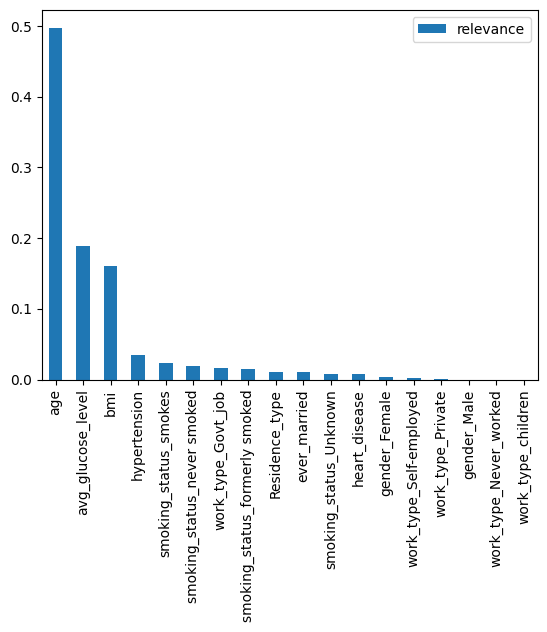

In [ ]:
df_feature_relevance = pd.DataFrame(data={"columns": list_columns_to_train_tree_1, "relevance": model_tree.best_estimator_.feature_importances_})
df_feature_relevance.sort_values(by="relevance", ascending=False, inplace=True)
df_feature_relevance.reset_index(drop=True, inplace=True)
plot_feature_relevance = df_feature_relevance.plot(kind="bar")
plot_feature_relevance.set_xticklabels(df_feature_relevance["columns"]);

Sin duda alguna, la edad "age" es la variable más relevante, seguida de "avg_glucose_level" y "bmi".

El resto de columnas tienen una relevancia residual.

Vemos que algunas variables, como "heart_disease", "hypertension" o "ever_married", las cuales parecía que iban a tener un gran impacto en la predicción en base a las correlaciones, en realidad apenas afectan. La explicación más razonable es que la relación entre estas variables y la variable objetivo en realidad es una correlación puramente estadística y no una relación causal. A su vez, la causa de que haya una correlación estadística es que estas variables tienen una relación de causalidad con otras variables como "age" (por ejemplo, a mayor edad, mayor probabilidad de que una persona haya estado alguna vez casada en su vida o mayor probabilidad de que haya tenido problemas de corazón), teniendo estas últimas una relación también de causalidad con la variable objetivo.

Para terminar, podemos representar el árbol de decisión:

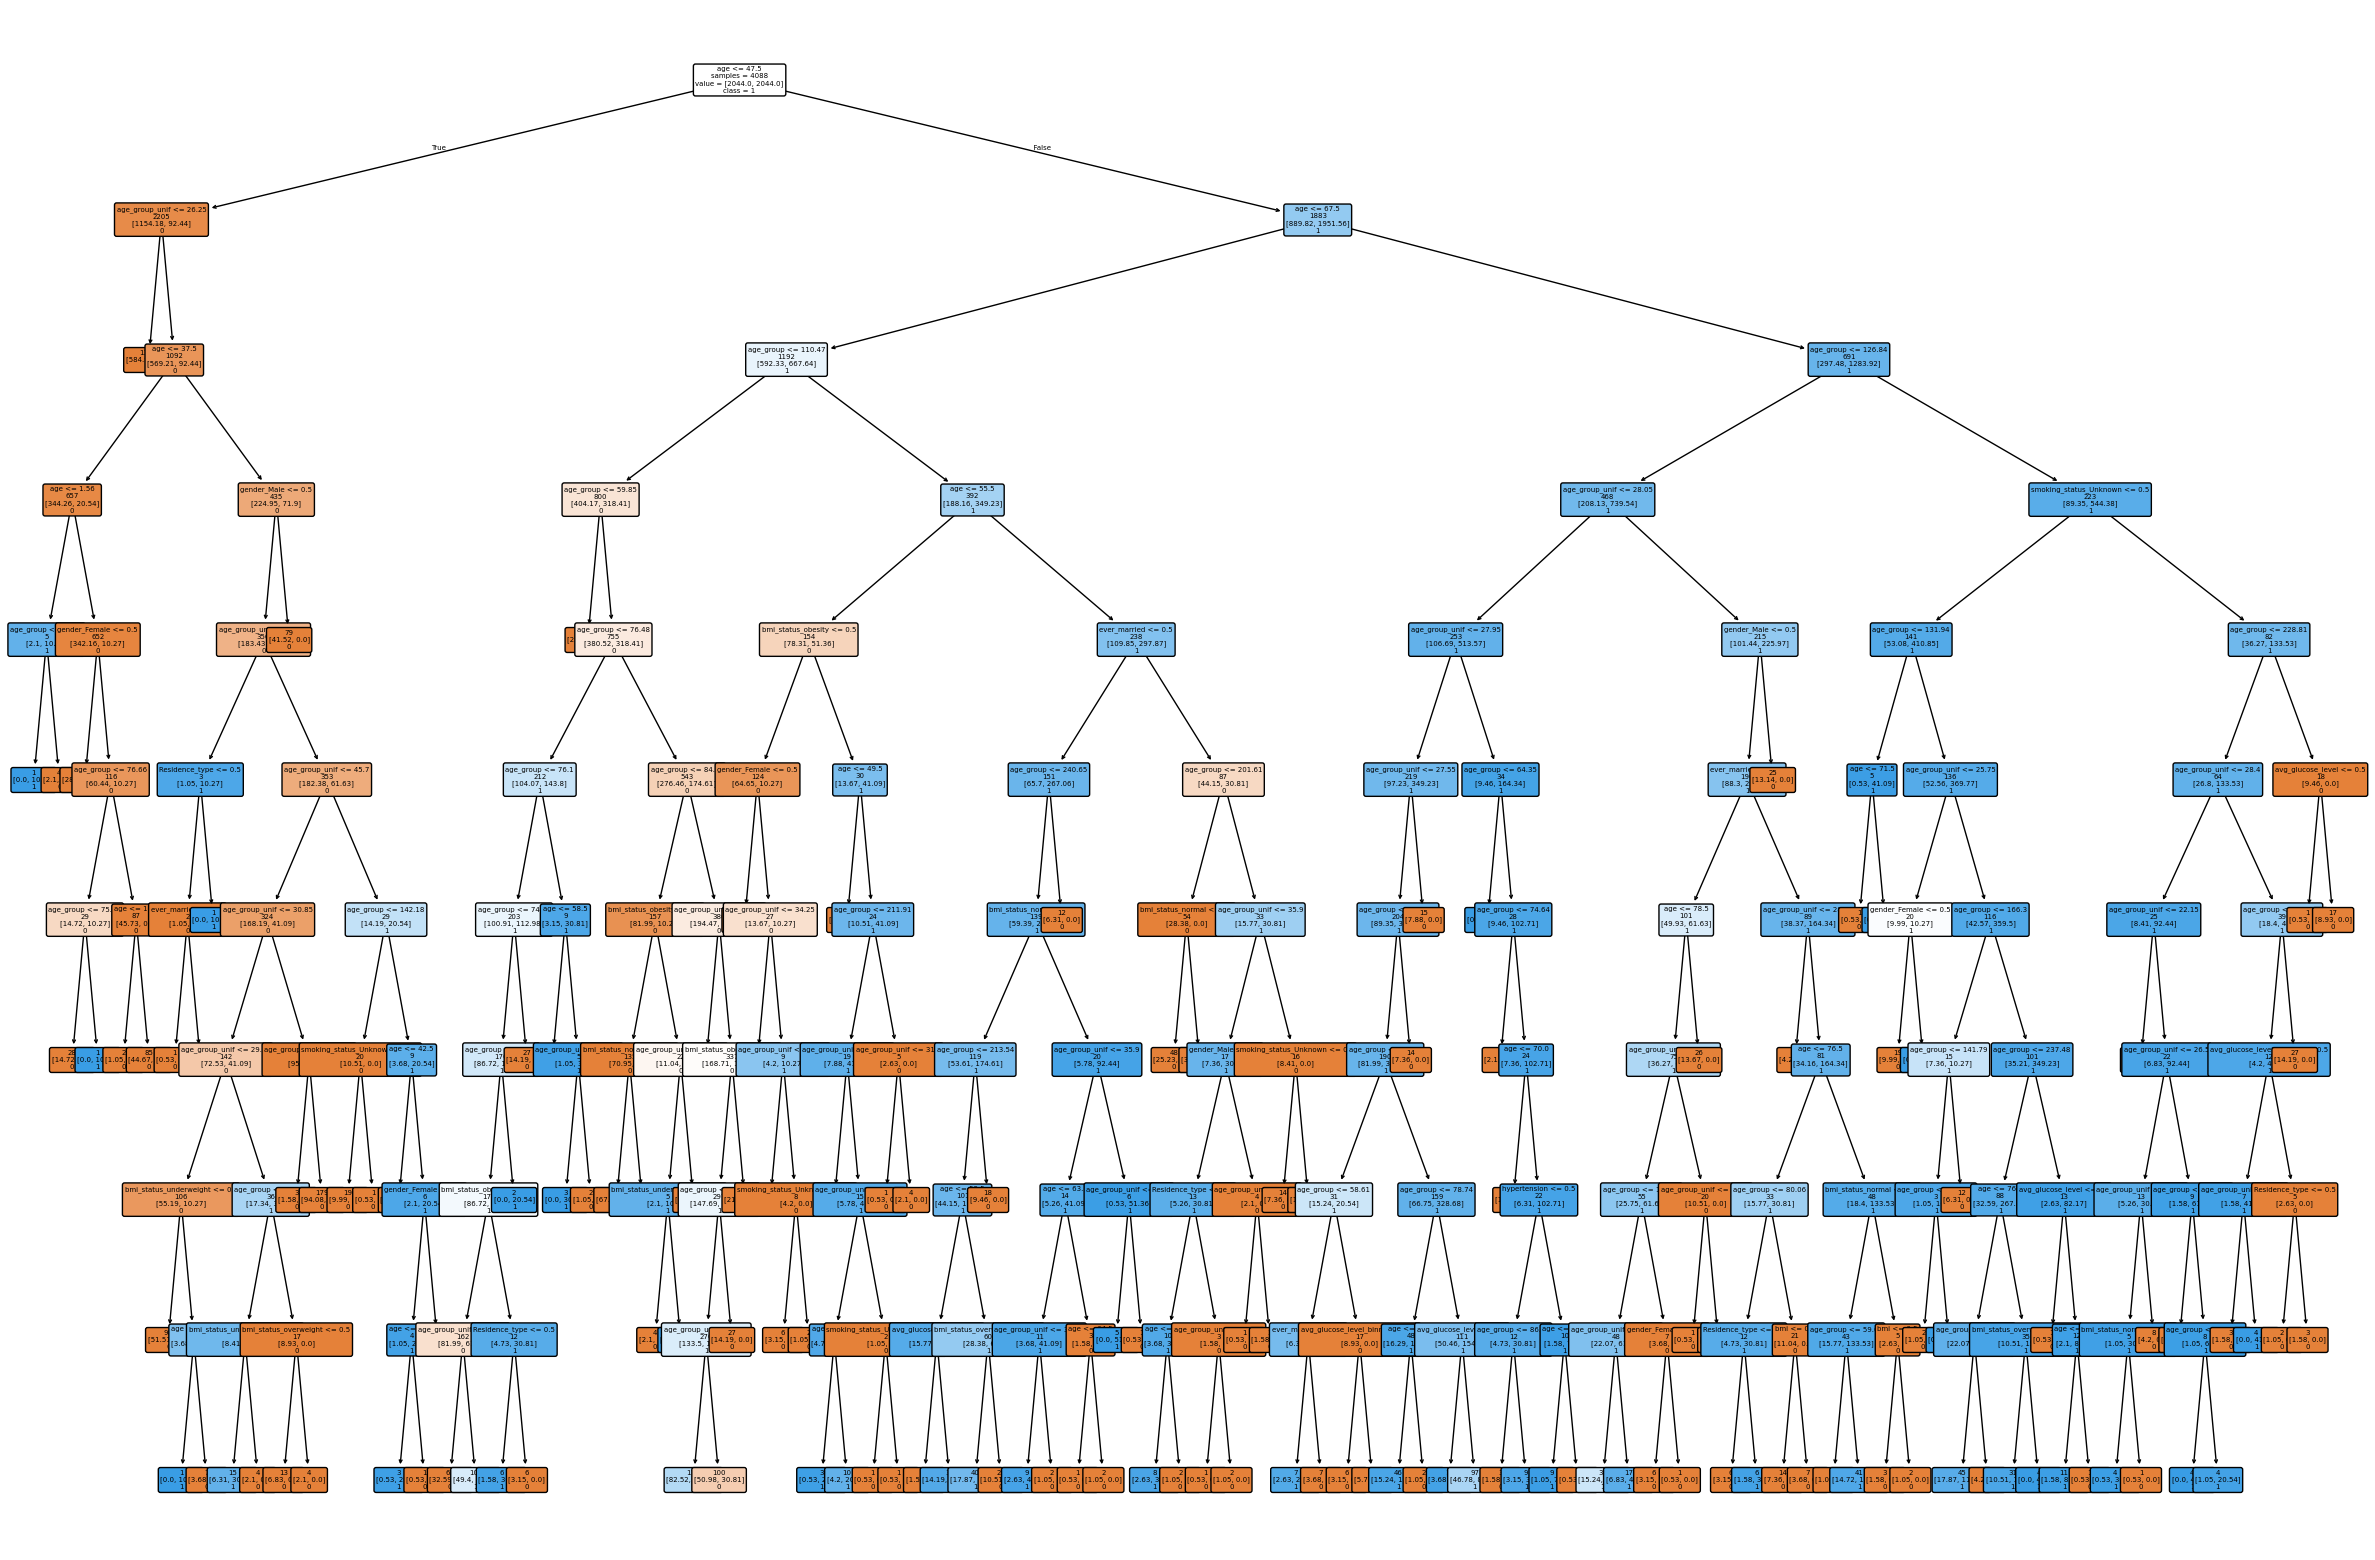

In [ ]:
plt.figure(figsize=(30,20))

a = tree.plot_tree(model_tree.best_estimator_,
                   filled=True,
                   rounded=True,
                   fontsize=5,
                   feature_names=X_train.columns,
                   class_names=y_train.astype(dtype=str).unique().tolist(),
                   label="root",
                   precision=2,
                   impurity=False)

Como vemos, aquí hay demasiado información como para que podamos procesarla a golpe de vista. Conviene mostrar solo una pequeña parte:

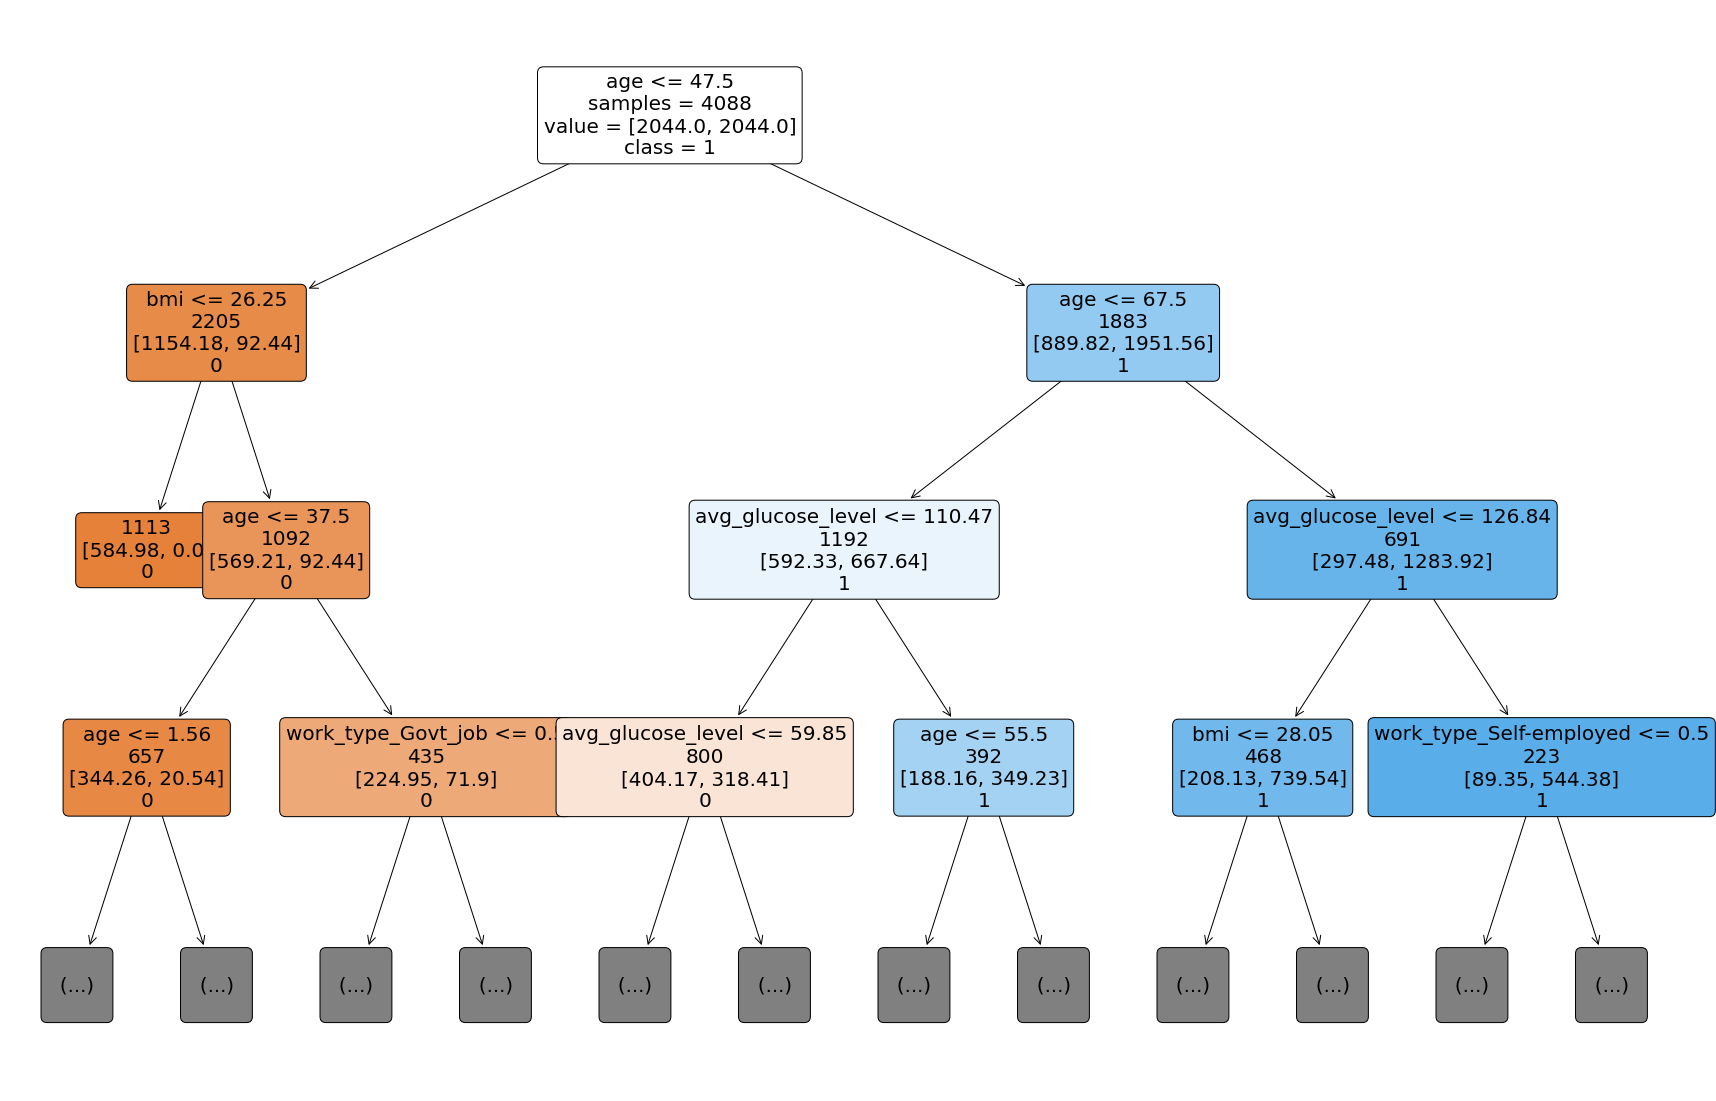

In [ ]:
plt.figure(figsize=(30,20))

a = tree.plot_tree(model_tree.best_estimator_,
                   filled=True,
                   rounded=True,
                   fontsize=20,
                   max_depth=3,
                   feature_names=list_columns_to_train_tree_1,
                   class_names=y_train.astype(dtype=str).unique().tolist(),
                   label="root",
                   precision=2,
                   impurity=False)

Aquí vemos que casi todas las divisiones que se realizan en los primeros puntos del árbol se basan en "age", "bmi" y "avg_glucose_level", confirmando lo que hemos visto en el análisis de relevancia de variables.

# Random Forest

## Entrenamiento

Introducimos el Random Forest.

Empezamos por definir la malla de hiperparámetros. Los explicamos aquí:
* "n_estimators" es el número de árboles a considerar.
* "max_features" es el número de columnas a considerar en cada árbol; es decir, en vez de tomar en cada uno de los árboles todas las columnas, se considerará una parte de ellas al azar. Si es None, entonces se consideran todas. El valor "sqrt" indica que nos quedamos con la raíz cuadrada del número total de columnas.
* "boostrap" es una variable lógica que indica si hacemos *bootstrapping* (True) o no (False).
* "oob_score" es, de nuevo, una variable lógica. Si vale True, entonces el Random Forest nos da el error que cometemos en la parte del conjunto de entrenamiento que queda fuera del *bootstrapping*.
* Finalmente, "max_depth", "criterion" y "class_weight" ya los hemos visto en el árbol de decisión. Comentar que, en el caso de "class_weight", ahora también puede valer "balanced_subsample"; esto significa que el factor que se tiene en cuenta para pesar los errores en función de la proporción de las clases se hace con el conjunto que ha entrado en *bootstrapping* y no el conjunto de entrenamiento total.

Podéis venir aquí https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html para saber más al respecto.

In [ ]:
dict_params = {"n_estimators": [50, 100, 200],
               "max_depth": [3, 5, 10],
               "criterion": ["entropy", "gini"],
               "max_features": ["sqrt", None],
               "bootstrap": [True],
               "oob_score": [True],
               "class_weight": ["balanced", "balanced_subsample", None],
               "max_samples": [0.6, 0.8]
              }

Usaremos la misma validación cruzada que antes, así como la misma métrica de validación (*F1-score*).

In [ ]:
model_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=42997296),
                        param_grid=dict_params,
                        cv=stratKF,
                        refit=True,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        scoring="f1"
                        )

Entrenamos. De nuevo, nos quedamos con los "age", "bmi" y "avg_glucose_level" originales.

In [ ]:
list_columns_to_train_RF = ['Residence_type', 'age',
       'avg_glucose_level', 'bmi',
       'ever_married', 'gender_Female', 'gender_Male', 'heart_disease',
       'hypertension', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children']
list_columns_to_train_RF.sort()
model_RF.fit(X_train[list_columns_to_train_RF], y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=42997296), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 10],
                         'max_features': ['sqrt', None],
                         'max_samples': [0.6, 0.8],
                         'n_estimators': [50, 100, 200], 'oob_score': [True]},
             return_train_score=True, scoring='f1', verbose=1)

In [ ]:
# imprimimos por pantalla los mejores hiperparámetros
print("Los hiperparámetros del modelo son {}.".format(model_RF.best_params_))

# imprimimos por pantalla las magnitudes que nos interesan
print(classification_report(y_train, model_RF.predict(X_train[list_columns_to_train_RF])))

print("F1-score en validación cruzada es: {}".format(model_RF.cv_results_["mean_test_score"].max()))

cr_rf = classification_report(y_test, model_RF.predict(X_test[list_columns_to_train_RF]))

print(cr_rf)

Los hiperparámetros del modelo son {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_samples': 0.6, 'n_estimators': 200, 'oob_score': True}.
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3889
           1       0.19      0.82      0.31       199

    accuracy                           0.82      4088
   macro avg       0.59      0.82      0.61      4088
weighted avg       0.95      0.82      0.87      4088

F1-score en validación cruzada es: 0.27414070405574176
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.16      0.64      0.26        50

    accuracy                           0.82      1022
   macro avg       0.57      0.73      0.58      1022
weighted avg       0.94      0.82      0.87      1022



Sin duda, se trata de un modelo mejor que el anterior.

De nuevo, guardamos las predicciones para comparar más adelante los modelos:

In [ ]:
list_preds_RF = model_RF.predict(X_test[list_columns_to_train_RF])

## Relevancia de la métrica

Pasamos a evaluar el impacto de la métrica utilizada tanto en el entrenamiento como en la validación. E particular:

1. Dejaremos "class_weight" como None, de tal forma que mediremos por igual el error en 0 y en 1.
2. Utilizaremos como "scoring" el valor por defecto, que es la *accuracy*.
3. Utilizaremos como "scoring" el *recall*.

### Ignorando el desequilibrio entre clases

Comenzamos por fijar "class_weight" a None para que el error de ambas clases se considere por igual.

In [ ]:
# definimos el objeto
model_RF_no_balanced = GridSearchCV(estimator=RandomForestClassifier(random_state=42997296),
                                    param_grid={"n_estimators": [50, 100, 200],
                                                "max_depth": [3, 5, 10],
                                                "criterion": ["entropy", "gini"],
                                                "max_features": ["sqrt", None],
                                                "bootstrap": [True],
                                                "oob_score": [True],
                                                "class_weight": [None],
                                                "max_samples": [0.6, 0.8]
                                                },
                                    cv=stratKF,
                                    refit=True,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True,
                                    scoring="f1")

# entrenamos
model_RF_no_balanced.fit(X_train[list_columns_to_train_RF], y_train)

# imprimimos por pantalla los mejores hiperparámetros
print("Los hiperparámetros del modelo son {}.".format(model_RF_no_balanced.best_params_))

# imprimimos por pantalla las magnitudes que nos interesan
print(classification_report(y_train, model_RF_no_balanced.predict(X_train[list_columns_to_train_RF])))

print("F1-score en validación cruzada es: {}".format(model_RF_no_balanced.cv_results_["mean_test_score"].max()))

print(classification_report(y_test, model_RF_no_balanced.predict(X_test[list_columns_to_train_RF])))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Los hiperparámetros del modelo son {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_samples': 0.8, 'n_estimators': 50, 'oob_score': True}.
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3889
           1       1.00      0.53      0.70       199

    accuracy                           0.98      4088
   macro avg       0.99      0.77      0.84      4088
weighted avg       0.98      0.98      0.97      4088

F1-score en validación cruzada es: 0.05393939393939393
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.25      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.60      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



Hay varias cosas interesantes que analizar:
* Ahora el rendimiento en entrenamiento es mucho mejor, a excepción del *recall*.
* Nos llevamos la primera sorpresa desagradable cuando calculamos el *F1-score* en validación cruzada. De un 27% que teníamos antes, hemos caído a un 0.05%. Ahora vemos el precio a pagar por no darle pesos diferentes a las clases.
* La *precision* y el *recall* en test para la clase 0 también son de alta calidad, incluso más que en el modelo anterior.
* La *precision* para la clase 1 es incluso mejor que antes
* Sin embargo, el *recall* cae estrepitosamente y, con él, el *F1-score*.

Para entender el origen de la diferencia, veamos cuántas veces el modelo predice ahora "stroke"=1 en test frente a lo que predecía antes:

In [ ]:
print("El número de veces que el modelo sin equilibrar las clases predice 'stroke' = 1 es:\n{},\nmientras que al equilibrar las clases era\n{}.".format(model_RF_no_balanced.predict(X_test[list_columns_to_train_RF]).sum(), (list_preds_RF == 1).sum()))

El número de veces que el modelo sin equilibrar las clases predice 'stroke' = 1 es:
4,
mientras que al equilibrar las clases era
198.


*Grosso modo*, el modelo está prediciendo que la variable objetivo es 0 casi siempre. Esto da una *accuracy* bastante alta, pero se nos escapan muchísimos positivos.

### Métrica de validación: *accuracy*

Consideremos ahora que validamos con la *accuracy* en vez de con el *F1-score*:

In [ ]:
# definimos el objeto
model_RF_no_f1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42997296),
                              param_grid={"n_estimators": [50, 100, 200],
                                          "max_depth": [3, 5, 10],
                                          "criterion": ["entropy", "gini"],
                                          "max_features": ["sqrt", None],
                                          "bootstrap": [True],
                                          "oob_score": [True],
                                          "class_weight": ["balanced", "balanced_subsample", None],
                                          "max_samples": [0.6, 0.8]
                                         },
                              cv=stratKF,
                              refit=True,
                              verbose=1,
                              n_jobs=-1,
                              return_train_score=True,
                              scoring="accuracy"
                             )

# entrenamos
model_RF_no_f1.fit(X_train[list_columns_to_train_RF], y_train)

# imprimimos por pantalla los mejores hiperparámetros
print("Los hiperparámetros del modelo son {}.".format(model_RF_no_f1.best_params_))

# imprimimos por pantalla las magnitudes que nos interesan
print(classification_report(y_train, model_RF_no_f1.predict(X_train[list_columns_to_train_RF])))

print("accuracy en validación cruzada es: {}".format(model_RF_no_f1.cv_results_["mean_test_score"].max()))

print(classification_report(y_test, model_RF_no_f1.predict(X_test[list_columns_to_train_RF])))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Los hiperparámetros del modelo son {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 50, 'oob_score': True}.
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3889
           1       0.00      0.00      0.00       199

    accuracy                           0.95      4088
   macro avg       0.48      0.50      0.49      4088
weighted avg       0.91      0.95      0.93      4088

accuracy en validación cruzada es: 0.9513211014116288
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



Se ha acentuado aún más lo que nos ha pasado al poner "class_weight" como None: ahora el modelo predice **siempre** que la variable objetivo es 0. Esto da una *accuracy* altísima, de un 95%, pero el rendimiento en la clase 1 es nulo: tenemos *precision* y *recall* 0.

### Métrica de validación: *recall*

Consideramos ahora el *recall* como métrica de validación. Esto ayudará a minimizar los falsos negativos, pero puede haber muchos falsos positivos. Veamos qué pasa:

In [ ]:
# definimos el objeto
model_RF_recall = GridSearchCV(estimator=RandomForestClassifier(random_state=42997296),
                               param_grid={"n_estimators": [1, 50, 100, 200],
                                           "max_depth": [1, 3, 5, 10],
                                           "criterion": ["entropy", "gini"],
                                           "max_features": ["sqrt", None],
                                           "bootstrap": [True],
                                           "oob_score": [True],
                                           "class_weight": ["balanced", "balanced_subsample", None],
                                           "max_samples": [0.6, 0.8]
                                          },
                               cv=stratKF,
                               refit=True,
                               verbose=1,
                               n_jobs=-1,
                               return_train_score=True,
                               scoring="recall"
                              )

# entrenamos
model_RF_recall.fit(X_train[list_columns_to_train_RF], y_train)

# imprimimos por pantalla los mejores hiperparámetros
print("Los hiperparámetros del modelo son {}.".format(model_RF_recall.best_params_))

# imprimimos por pantalla las magnitudes que nos interesan
print(classification_report(y_train, model_RF_recall.predict(X_train[list_columns_to_train_RF])))

print("El recall en validación cruzada es: {}".format(model_RF_recall.cv_results_["mean_test_score"].max()))

print(classification_report(y_test, model_RF_recall.predict(X_test[list_columns_to_train_RF])))

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Los hiperparámetros del modelo son {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 1, 'oob_score': True}.
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      3889
           1       0.12      0.89      0.21       199

    accuracy                           0.67      4088
   macro avg       0.56      0.78      0.50      4088
weighted avg       0.95      0.67      0.77      4088

El recall en validación cruzada es: 0.8947435897435898
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       972
           1       0.11      0.80      0.19        50

    accuracy                           0.67      1022
   macro avg       0.55      0.73      0.49      1022
weighted avg       0.94      0.67      0.76      1022



Hay varias cosas interesantes a comentar:
* Efectivamente, el *recall* para 1 es ahora sustancialmente mayor que antes, tal y como era de prever, mientras que el resto de parámetros
* La gran sorpresa nos la damos cuando vemos los mejores hiperparámetros. En particular:
    * n_estimators (o número de árboles) es 1
    * max_depth también es 1

Tratemos de entender esto. Como vemos, el modelo cuenta con un único árbol. Podemos representarlo.

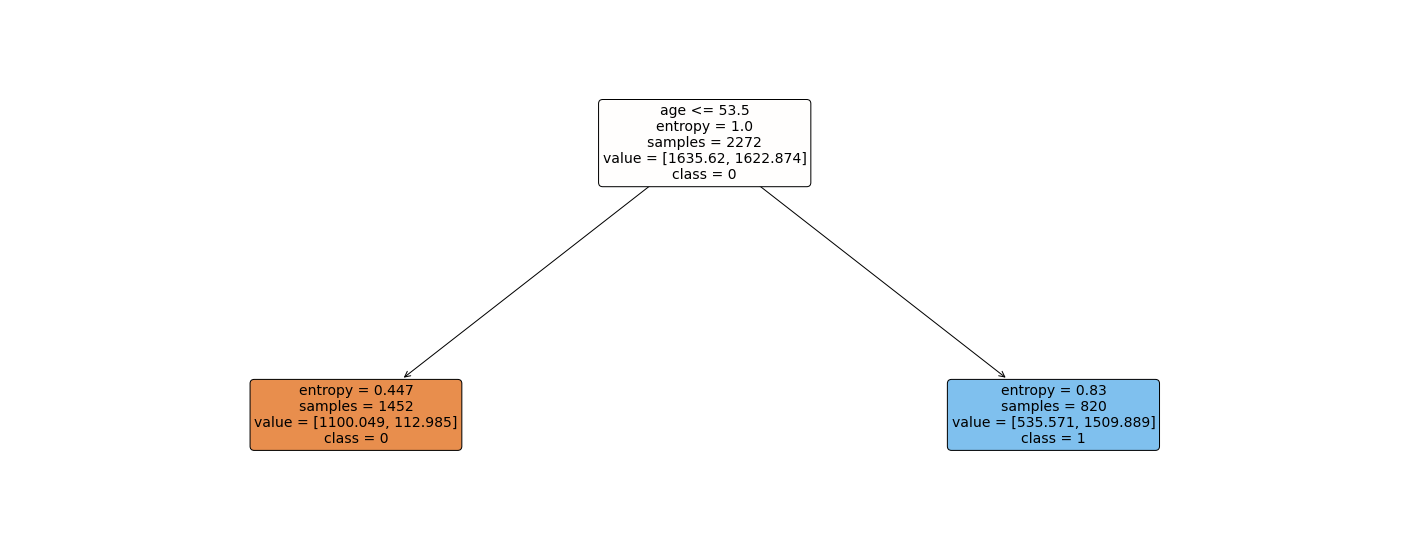

In [ ]:
plt.figure(figsize=(25,10))

tree_RF = model_RF_recall.best_estimator_.estimators_[0]

a = tree.plot_tree(tree_RF,
                   filled=True,
                   rounded=True,
                   fontsize=14,
                   feature_names=X_train.columns,
                   class_names=y_train.astype(dtype=str).unique().tolist())

Como vemos, la única variable considerada es la edad "age": si es menor o igual que 53,5, entonces predice que no va a haber accidente cerebrovascular, mientras que, en caso contrario, sí que lo habrá. Evidentemente, se trata de un modelo demasiado simple. Para ilustrarlo, reproducimos aquí la gráfica de "stroke" en función de "age", así como las predicciones acordes a este último modelo:

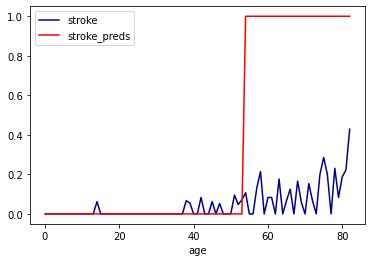

In [ ]:
df_results_recall = pd.concat(objs=[X_test.reset_index(drop=True, inplace=False),
                                    pd.Series(model_RF_recall.predict(X_test[list_columns_to_train_RF]),
                                              name="stroke_preds")],
                             axis=1)

df_results_recall = pd.concat(objs=[df_results_recall, y_test.reset_index(drop=True, inplace=False)], axis=1)

fig.set_size_inches(20, 5)

ax = df_results_recall[["age", "stroke"]].groupby(by="age").mean().plot(color="DarkBlue");

df_results_recall[["age", "stroke_preds"]].groupby(by="age").mean().plot(color="Red", ax=ax);

Si bien es evidente que a más edad más probabilidad de sufrir un accidente cerebrovascular, queda claro que esto tampoco es lo que queremos.

# XGBoost

## Entrenamiento

Pasamos a considerar el XGBoost. Empezamos por definir la malla de hiperparámetros. Consideramos los siguientes valores:
* "learning_rate" nos da una medida de lo grande que es la corrección que van introduciendo los nuevos árboles: a mayor "learning_rate", más grande es la corrección que introduce un nuevo árbol.
* "objective" es la métrica que utilizaremos para encontrar el modelo. Usamos "binary:logistic", que es como usar la "accuracy".
* "tree_method" es la técnica que utilizamos para encontrar las mejores divisiones. Los posibles valores son "exact", que toma todas las divisiones y se queda la mejor, "approx", que considera ciertos percentiles de las variables a la hora de hacer las divisiones y "hist", que, sin entrar demasiado en detalle, hace las divisiones teniendo en cuenta los histogramas de las variables. Aquí nos quedamos con "approx".
* "subsample" es el ratio de filas que considera el algoritmo para cada árbol.
* "colsample_bytree" es el ratio de columnas que considera el algoritmo para cada árbol.
* "scale_pos_weight" es conceptualmente equivalente a "class_weight" del árbol de decisión y del Random Forest, con la diferencia de que aquí no vale con decir "balanced", sino que tenemos que introducir el ratio entre casos positivos y negativos.
* Finalmente, "n_estimators" y "max_depth" ya los hemos visto con anterioridad.

Para saber más, podéis ir aquí: https://xgboost.readthedocs.io/en/latest/parameter.html

In [19]:
float_ratio = (y_train == 0).sum() / (y_train == 1).sum()

dict_params = {"n_estimators": [100, 125, 150],
               "max_depth": [5, 10, 15],
               "learning_rate": [0.03, 0.01, 0.3],
               "objective": ["binary:logistic"],
               "tree_method": ["approx"],
               "subsample": [0.8, 1.0],
               "colsample_bytree": [0.6, 0.8],
               "scale_pos_weight": [1, float_ratio],
              }

Volvemos a definir el objeto para entrenar mediante validación cruzada:

In [20]:
model_XGB = GridSearchCV(estimator=XGBClassifier(random_state=42997296),
                         param_grid=dict_params,
                         cv=stratKF,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="f1"
                         )

Entrenamos, de nuevo con las variables originales:

In [21]:
list_columns_to_train_XGB = ['Residence_type', 'age',
       'avg_glucose_level', 'bmi',
       'ever_married', 'gender_Female', 'gender_Male', 'heart_disease',
       'hypertension', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children']


model_XGB.fit(X_train[list_columns_to_train_XGB], y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42997296, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.03, 0.01, 0.3],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 125, 150],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1, 19.542713567839197],
                         'subsample': [0.8, 1.0], 'tree_method': ['approx']},
             return_train_score=True, scoring='f1', verbose=1)

Los mejores hiperparámetros son:

In [23]:
print(model_XGB.best_params_)

{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 150, 'objective': 'binary:logistic', 'scale_pos_weight': 19.542713567839197, 'subsample': 1.0, 'tree_method': 'approx'}


Veamos el informe del rendimiento en entrenamiento:

In [24]:
print(classification_report(y_train, model_XGB.predict(X_train[list_columns_to_train_XGB])))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3889
           1       0.62      1.00      0.77       199

    accuracy                           0.97      4088
   macro avg       0.81      0.98      0.88      4088
weighted avg       0.98      0.97      0.97      4088



In [25]:
print("El F1-score en validación cruzada es: {}".format(model_XGB.cv_results_["mean_test_score"].max()))

El F1-score en validación cruzada es: 0.2892555756807811


Veamos el informe del rendimiento en test:

In [26]:
print(classification_report(y_test, model_XGB.predict(X_test[list_columns_to_train_XGB])))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       972
           1       0.20      0.22      0.21        50

    accuracy                           0.92      1022
   macro avg       0.58      0.59      0.58      1022
weighted avg       0.92      0.92      0.92      1022



De nuevo, el resultado es claramente mejor que el del árbol de decisión, pero es comparable al del Random Forest. En particular, el *F1-score* se ha mantenido (0,26), la *precision* ha mejorado (de 0,16 a 0,22) y el *recall* ha empeorado bastante (de 0,64 a 0,34). Esto no es de extrañar. La conclusión a posteriori es que la complejidad del problema está a medio camino entre la potencia del XGBoost y la simplicidad del Random Forest.

Dicho esto, sí que podemos determinar cuál de los modelos es mejor en base a la *precision* y al *recall*. Como ya hemos comentado, dependiendo del problema, puede interesar darle más peso a una magnitud o a la otra. En este caso, habría que ver cuáles son los riesgos de tener gente con problemas potenciales sin diagnosticar frente a los efectos secundarios de aplicar el tratamiento médico a gente que en realidad no va a desarrollar estos problemas.

Finalmente, volvemos a quedarnos con las predicciones:

In [27]:
list_preds_XGB = model_XGB.predict(X_test[list_columns_to_train_XGB])

## Selección y modificación de variables

A partir del análisis que hicimos de la relevancia de variables con el árbol de decisión, podemos entrenar un nuevo modelo usando solo las tres variables principales del problema

In [28]:
list_columns_to_train_XGB_2 = ['age', 'avg_glucose_level', 'bmi']

model_XGB_var_sel = GridSearchCV(estimator=XGBClassifier(random_state=42997296),
                         param_grid=dict_params,
                         cv=stratKF,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="f1"
                         )

model_XGB_var_sel.fit(X_train[list_columns_to_train_XGB_2], y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42997296, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.03, 0.01, 0.3],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 125, 150],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1, 19.542713567839197],
                         'subsample': [0.8, 1.0], 'tree_method': ['approx']},
             return_train_score=True, scoring='f1', verbose=1)

In [ ]:
print(classification_report(y_train, model_XGB_var_sel.predict(X_train[list_columns_to_train_XGB_2])))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3889
           1       0.22      0.98      0.36       199

    accuracy                           0.83      4088
   macro avg       0.61      0.90      0.63      4088
weighted avg       0.96      0.83      0.88      4088



In [ ]:
print("El F1-score en validación cruzada es: {}".format(model_XGB_var_sel.cv_results_["mean_test_score"].max()))

El F1-score en validación cruzada es: 0.2643222548432294


In [ ]:
print(classification_report(y_test, model_XGB_var_sel.predict(X_test[list_columns_to_train_XGB_2])))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.15      0.68      0.25        50

    accuracy                           0.80      1022
   macro avg       0.57      0.74      0.57      1022
weighted avg       0.94      0.80      0.85      1022



Llegamos a varias conclusiones interesantes:
* El rendimiento del modelo no está lejos de aquel con todas las variables.
* Para existencia de accidente cerebrovascular, vemos que la *precision* ha bajado y el *recall* ha subido. Esto es razonable, teniendo en cuenta que en un modelo con solo "age" es posible encontrar *recalls* muy altos, tal y como hemos visto en el caso en el que validamos con *recall*.

En cualquier caso, el hecho de que con solo tres variables obtengamos resultados razonables es bastante positivo. Para este problema, un entrenamiento lleva unos pocos minutos. Pero para problemas con muchos más datos, la diferencia de tiempos entre usar todas las variables y solo unas pocas puede ser de horas, de tal forma que es preferible sacrificar parte del rendimiento del modelo para tener los resultados a tiempo.

Visto esto, podemos estudiar si el modelo mejora o no al usar las variables transformadas a partir de las variables numéricas originales. Empezamos con la edad agrupada en los grupos que hemos definido antes, el nivel de glucosa distribuido de forma uniforme y, de momento, el "bmi" original:

In [ ]:
X_train['age_group_unif'] = X_train['age_group_unif'].apply(lambda x: x.left).astype(dtype=int)
X_test['age_group_unif'] = X_test['age_group_unif'].apply(lambda x: x.left).astype(dtype=int)

In [ ]:
list_columns_to_train_XGB_3 = ['age_group_unif',
                               'avg_glucose_level_binned',
                               'bmi']

model_XGB_var_sel.fit(X_train[list_columns_to_train_XGB_3], y_train)
print(classification_report(y_train, model_XGB_var_sel.predict(X_train[list_columns_to_train_XGB_3])))
print("El F1-score en validación cruzada es: {}".format(model_XGB_var_sel.cv_results_["mean_test_score"].max()))
print(classification_report(y_test, model_XGB_var_sel.predict(X_test[list_columns_to_train_XGB_3])))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[09:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3889
           1       0.28      0.98      0.43       199

    accuracy                           0.87      4088
   macro avg       0.64      0.93      0.68      4088
weighted avg       0.96      0.87      0.90      4088

El F1-score en validación cruzada es: 0.25910784152554
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.14      0.48      0.22        50

    accuracy                           0.84      1022
   macro avg       0.56   

De nuevo, obtenemos resultados por debajo del modelo original.

Probemos a incluir "bmi" categorizada con "one-hot encoding":

In [ ]:
list_columns_to_train_XGB_4 = ['age_group',
                               'avg_glucose_level_binned',
                               'bmi_status_underweight',
                               'bmi_status_normal',
                               'bmi_status_overweight',
                               'bmi_status_obesity']

model_XGB_var_sel.fit(X_train[list_columns_to_train_XGB_4], y_train)
print(classification_report(y_train, model_XGB_var_sel.predict(X_train[list_columns_to_train_XGB_4])))
print("El F1-score en validación cruzada es: {}".format(model_XGB_var_sel.cv_results_["mean_test_score"].max()))
print(classification_report(y_test, model_XGB_var_sel.predict(X_test[list_columns_to_train_XGB_4])))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[09:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3889
           1       0.15      0.79      0.25       199

    accuracy                           0.77      4088
   macro avg       0.57      0.78      0.55      4088
weighted avg       0.95      0.77      0.83      4088

El F1-score en validación cruzada es: 0.2342428511909683
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       972
           1       0.12      0.66      0.21        50

    accuracy                           0.75      1022
   macro avg       0.55 

Una vez más, no logramos recuperar el resultado obtenido con las variables originales.

La conclusión es que el XGBoost es capaz de captar la complejidad de las variables al completo de tal forma que, reducir la información que proporcionan, no ayuda.

# Regresión logística

## Entrenamiento

Pasamos a considerar modelos paramétricos. Empezamos por regresión logística.

Notar que, al tratarse de un modelo paramétrico, tenemos que considerar las variables escaladas. Empezamos por sustituir "age", "avg_glucose_level" y "bmi" por sus versiones:

In [ ]:
X_train_no_scaling = X_train.copy()
X_test_no_scaling = X_test.copy()

X_train[["age", "avg_glucose_level", "bmi"]] = X_train_sc0
X_test[["age", "avg_glucose_level", "bmi"]] = X_test_sc0

De momento, el único hiperparámetro con el que jugamos es "class_weight", que es el mismo que en el árbol de decisión y el Random Forest. De nuevo, consideramos que puede ser None o "balanced", significando ambos valores lo mismo que en los casos anteriores.

Por otra parte, fijamos "penalty" a "none". Esto significa que no usaremos regularización.

In [ ]:
list_columns_to_train_LR = ['Residence_type', 'age',
       'avg_glucose_level', 'bmi',
       'ever_married', 'gender_Female', 'gender_Male', 'heart_disease',
       'hypertension', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children']

dict_params = {"penalty": ["none"],
               "class_weight": [None, "balanced"]
              }

model_LR = GridSearchCV(estimator=LogisticRegression(random_state=42997296),
                         param_grid=dict_params,
                         cv=stratKF,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="f1"
                         )

model_LR.fit(X_train[list_columns_to_train_LR], y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(random_state=42997296), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': ['none']},
             return_train_score=True, scoring='f1', verbose=1)

Veamos los hiperparámetros:

In [ ]:
print(model_LR.best_params_)

{'class_weight': 'balanced', 'penalty': 'none'}


Como era de esperar en base a los resultados previos, la validación cruzada ha determinado que "balanced" es mejor que None para "class_weight". Veamos el rendimiento del modelo en entrenamiento, validación y test:

In [ ]:
print(classification_report(y_train, model_LR.predict(X_train[list_columns_to_train_LR])))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3889
           1       0.14      0.83      0.24       199

    accuracy                           0.74      4088
   macro avg       0.56      0.78      0.54      4088
weighted avg       0.95      0.74      0.82      4088



In [ ]:
print("El F1-score en validación cruzada es: {}".format(model_LR.cv_results_["mean_test_score"].max()))

El F1-score en validación cruzada es: 0.2374417360851912


In [ ]:
print(classification_report(y_test, model_LR.predict(X_test[list_columns_to_train_LR])))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       972
           1       0.12      0.70      0.21        50

    accuracy                           0.74      1022
   macro avg       0.55      0.72      0.53      1022
weighted avg       0.94      0.74      0.82      1022



Vemos que estamos lejos de los resultados con XGBoost y Random Forest. Esto no es para nada de extrañar. Sí que es interesante constatar que la precisión en test es similar a la del árbol de decisión, pero en entrenamiento está bastante por debajo, llegando a la conclusión de que la regresión logística no sobreajusta.

Guardamos las predicciones:

In [ ]:
list_preds_LR = model_LR.predict(X_test[list_columns_to_train_LR])

Para entender mejor el bajo rendimiento delo modelo, representemos en nuestro conjunto de entrenamiento puntos de un par de variables relevantes, como "age" y "avg_glucose_level", indicando si "stroke" es 1 o 0:

## Representación gráfca

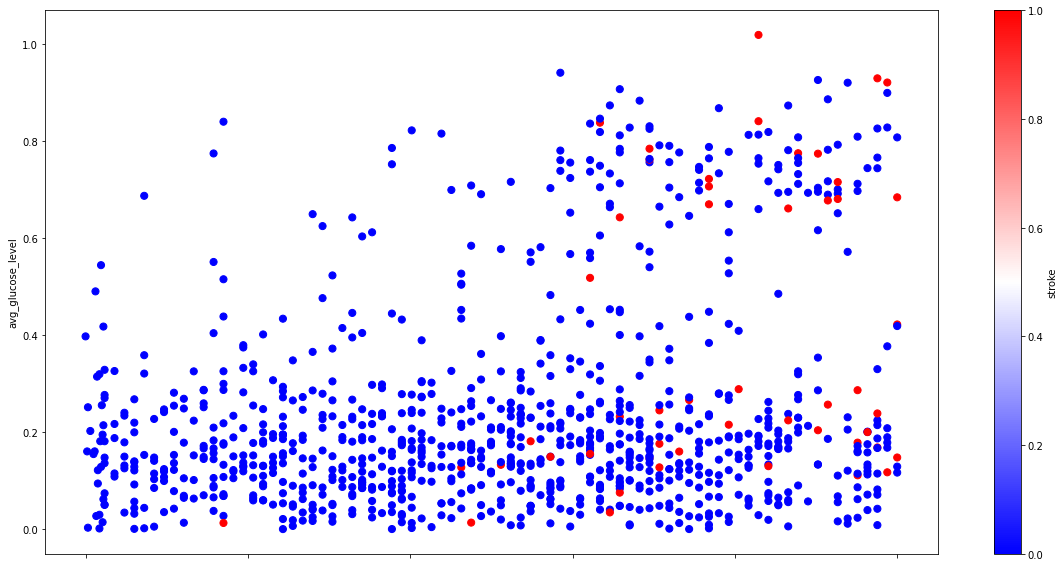

In [ ]:
ax = pd.concat(objs=[X_test[["age", "avg_glucose_level"]], y_test], axis=1).plot(kind='scatter',
                                                                            x='age',
                                                                            y='avg_glucose_level',
                                                                            c='stroke',
                                                                            s=50,
                                                                            colormap='bwr',
                                                                            figsize=(20, 10));

ax.set_xlabel("age");
ax.set_ylabel("avg_glucose_level");

In [ ]:
help(ax.set_xlabel)

Help on method set_xlabel in module matplotlib.axes._base:

set_xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the label for the x-axis.
    
    Parameters
    ----------
    xlabel : str
        The label text.
    
    labelpad : float, default: :rc:`axes.labelpad`
        Spacing in points from the axes bounding box including ticks
        and tick labels.  If None, the previous value is left as is.
    
    loc : {'left', 'center', 'right'}, default: :rc:`xaxis.labellocation`
        The label position. This is a high-level alternative for passing
        parameters *x* and *horizontalalignment*.
    
    Other Parameters
    ----------------
    **kwargs : `.Text` properties
        `.Text` properties control the appearance of the label.
    
    See Also
    --------
    text : Documents the properties supported by `.Text`.



Repetimos con "age" y "bmi":

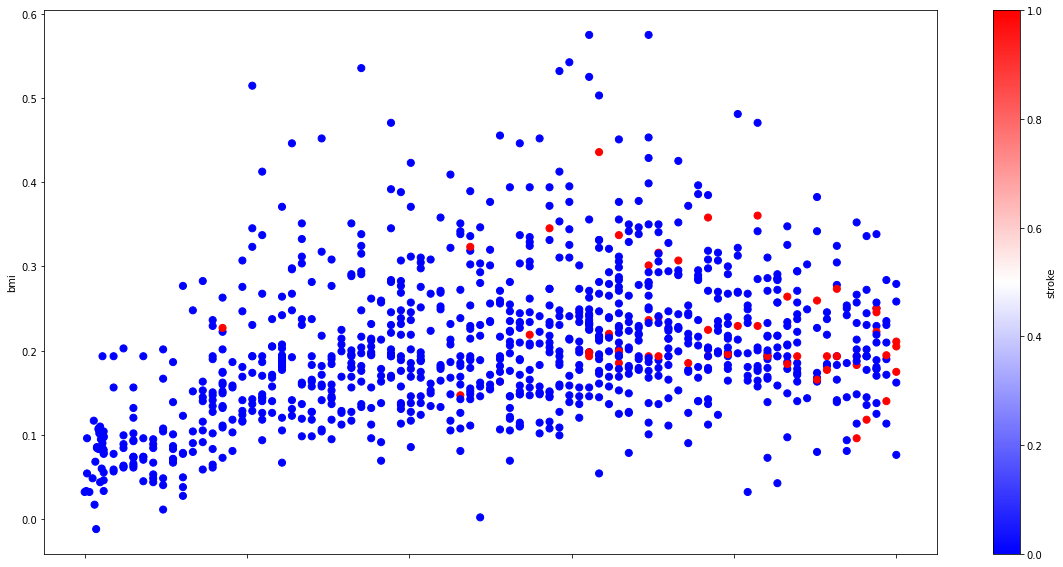

In [ ]:
ax = pd.concat(objs=[X_test[["age", "bmi"]], y_test], axis=1).plot(kind='scatter',
                                                                            x='age',
                                                                            y='bmi',
                                                                            c='stroke',
                                                                            s=50,
                                                                            colormap='bwr',
                                                                            figsize=(20, 10));

ax.set_xlabel("age");
ax.set_ylabel("bmi");

En ambos casos vemos que la frontera de decisión entre "stroke" 0 y 1 no es ni parecida a una línea recta. De ahí que la regresión logística no pueda dar un resultado satisfactorio con estos datos.

Tampoco parece que considerar términos de mayor grado en el modelo pueda cambiar demasiado las cosas.

Podría ser interesante probar con términos cruzados, como "bmi" * "age".

# SVM

## Entrenamiento

Para terminar, consideramos "Support Vector Machine" (SVM).

Como siempre, empezamos por definir la malla de hiperparámetros. Consideramos los siguientes valores:
* "C" nos da una medida de cuánto regularizamos. Valores bajos de "C" implican regularización alta y viceversa. La regularización es tipo L2.
* "kernel" es la función que se usa para calcular las distancias entre puntos. Tomamos "linear", que es como no hacer nada, "poly", que consiste en calcular expresiones polinómicas entre nuestros predictores $x$ y los puntos $p_k$ que usamos para calcular nuestros *kernels*:

$$
f_k = \left(\gamma \sum_i x_{i} p_{ki} + r\right)^d,
$$

"rbf", que es *radial basis function* o, como lo llamamos en las clases, *kernel* gaussiano,

$$
f_k = \exp(-\gamma||x-p_k||^2) = \exp\left(-\gamma \sum_i (x_i - p_{ki})^2\right),
$$

y "sigmoid", que, pese a su nombre, no es la sigmoide sino la tangente hiperbólica, que es muy similar a la sigmoide:

$$
f_k = \tanh\left(\gamma \sum_i x_{i} p_{ki} + r\right).
$$

$\gamma$, $r$ y $d$ se introducen en lo que sigue como otros hiperparámetros.

* "gamma" es el coeficiente que vemos en los distintos *kernels*. Cuanto mayor es, más complejo es nuestro modelo. Usamos los valores "auto", que implica tomar $\gamma$ igual a 1 partido por el número de columnas, y "scale", que es igual a la del caso anterior, pero dividida por la varianza de las variables.
* "coef0" es lo que hemos denotado como "r" en las expresiones del *kernel* polinómico y sigmoide.
* "class_weight" es, como en varios de los modelos anteriores, qué peso damos a los errores en función de la etiqueta original. Tomamos directamente "balanced", ya que ya hemos visto que la validación cruzada siempre determina que esta es la mejor opción.

Para saber más, podéis ir aquí: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
dict_params = {"C": [1, 3, 10, 30, 100, 300],
               "kernel": ["linear", "poly", "rbf", "sigmoid"],
               "degree": [2, 3, 4, 5],
               "gamma": ["scale", "auto"],
               "coef0": [0, 0.01, 0.1],
               "class_weight": ["balanced"]}

Volvemos a definir el objeto con el que hacemos validación cruzada sobre nuestra malla de hiperparámetros y entrenamos:

In [ ]:
list_columns_to_train_SVM = ['Residence_type', 'age',
       'avg_glucose_level', 'bmi',
       'ever_married', 'gender_Female', 'gender_Male', 'heart_disease',
       'hypertension', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children']

model_SVM = GridSearchCV(estimator=SVC(random_state=42997296),
                         param_grid=dict_params,
                         cv=stratKF,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="f1"
                         )

model_SVM.fit(X_train[list_columns_to_train_SVM], y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(random_state=42997296), n_jobs=-1,
             param_grid={'C': [1, 3, 10, 30, 100, 300],
                         'class_weight': ['balanced'], 'coef0': [0, 0.01, 0.1],
                         'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='f1', verbose=1)

In [ ]:
model_SVM.best_params_

{'C': 3,
 'class_weight': 'balanced',
 'coef0': 0.01,
 'degree': 2,
 'gamma': 'auto',
 'kernel': 'poly'}

Vemos que elige el *kernel* polinómico con grado 2. Veamos el rendimiento. Empezamos en entrenamiento:

In [ ]:
print(classification_report(y_train, model_SVM.predict(X_train[list_columns_to_train_SVM])))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84      3889
           1       0.14      0.86      0.25       199

    accuracy                           0.74      4088
   macro avg       0.57      0.80      0.55      4088
weighted avg       0.95      0.74      0.82      4088



Pasamos a considerar la métrica de validación (*F1-score*):

In [ ]:
print("El F1-score en validación cruzada es: {}".format(model_SVM.cv_results_["mean_test_score"].max()))

El F1-score en validación cruzada es: 0.23466101506638423


Y terminamos con el rendimiento en test:

In [ ]:
print(classification_report(y_test, model_SVM.predict(X_test[list_columns_to_train_SVM])))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.12      0.70      0.20        50

    accuracy                           0.73      1022
   macro avg       0.55      0.71      0.52      1022
weighted avg       0.94      0.73      0.81      1022



Vemos que obtenemos resultados muy parecidos a los de regresión logística y algo superiores a los del árbol de decisión, pero inferiores a Random Forest y XGBoost. Esto entra dentro de la normalidad.

Guardamos las predicciones:

In [ ]:
list_preds_SVM = model_SVM.predict(X_test[list_columns_to_train_SVM])

## Análisis de hiperparámetros

Hacemos en lo que sigue un análisis de la métrica de validación en función de los distintos hiperparámetros:

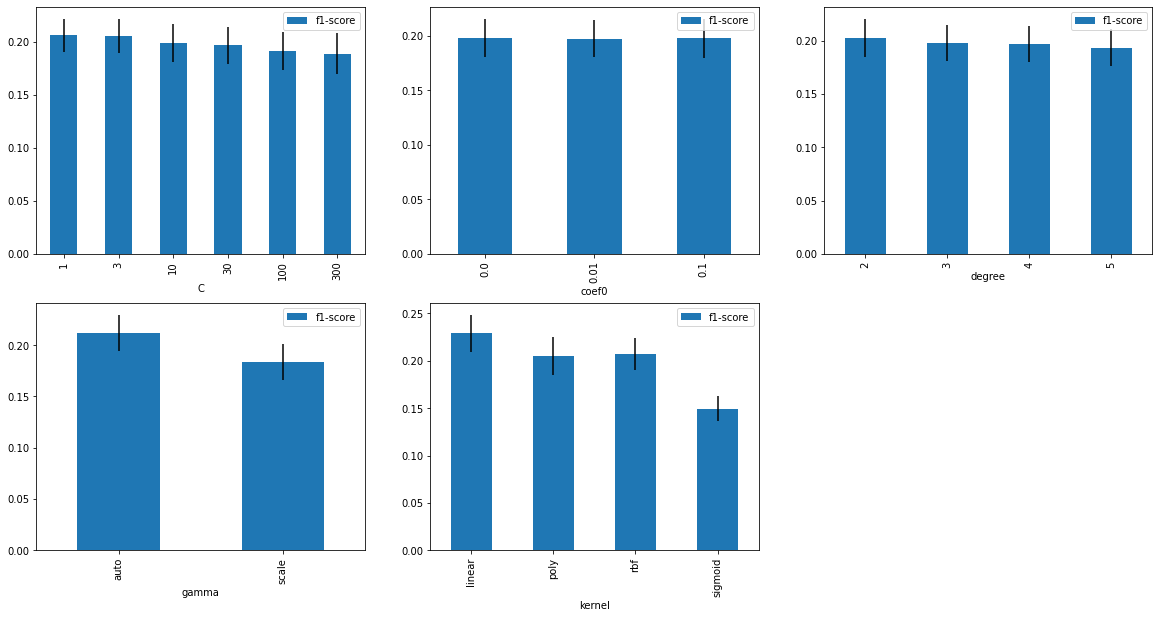

In [ ]:
dict_SVM_cv_results = {"C": model_SVM.cv_results_["param_C"].data,
                       "coef0": model_SVM.cv_results_["param_coef0"].data,
                       "degree": model_SVM.cv_results_["param_degree"].data,
                       "gamma": model_SVM.cv_results_["param_gamma"].data,
                       "kernel": model_SVM.cv_results_["param_kernel"].data,
                       "f1-score": model_SVM.cv_results_["mean_test_score"],
                       "std_score": model_SVM.cv_results_["std_test_score"]}
df_SVM_cv_results = pd.DataFrame(data=dict_SVM_cv_results)

fig, axes = plt.subplots(2, 3)
axes[-1, -1].axis('off')
fig.set_size_inches(20, 10)
df_SVM_cv_results[["C", "f1-score", "std_score"]].groupby("C").mean().plot(kind="bar", yerr="std_score", ax=axes[0,0]);
df_SVM_cv_results[["coef0", "f1-score", "std_score"]].groupby("coef0").mean().plot(kind="bar", yerr="std_score", ax=axes[0,1]);
df_SVM_cv_results[["degree", "f1-score", "std_score"]].groupby("degree").mean().plot(kind="bar", yerr="std_score", ax=axes[0,2]);
df_SVM_cv_results[["gamma", "f1-score", "std_score"]].groupby("gamma").mean().plot(kind="bar", yerr="std_score", ax=axes[1,0]);
df_SVM_cv_results[["kernel", "f1-score", "std_score"]].groupby("kernel").mean().plot(kind="bar", yerr="std_score", ax=axes[1,1]);


Lo que se muestra es el *F1-score* promedio para los distintos valores de cada hiperparámetro. Las barras de error se corresponden a la desviación estándar. Vemos varias cosas a destacar:
* C: Tiende a ayudar más cuanto menor es, es decir, cuanto mayor es la regularización. Esto nos da una pista de que el SVM, sin regularización, está sobreajustando.
* coef0 y degree no son muy relevantes
* Parece algo superior no escalar gamma.
* El mejor *kernel* desde el punto de vista estadísticoes el lineal. A esto le sigue el gaussiano y el polinómico, prácticamente empatados. En última posición, sin duda, el sigmoide. Sin embrago, la mejor combinación particular de hiperparámetros contiene el *kernel* polinómico y no el lineal.

# Comparación entre modelos

Para terminar, si bien ya hemos comentado de palabra cómo se comparan los modelos que hemos construido utilizando diferentes algoritmos, realizamos en lo que sigue esta comparativa de forma más visual. En concreto, mostramos *recall*, *precision* y *f1-score* en el conjunto de test para los distintos modelos, así como para los modelos triviales que definimos al principio (la moda, el aleatorio equiprobable y el aleatorio proporcional a la frecuencia de cada valor de la variable objetivo).

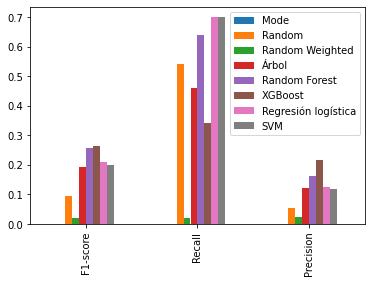

In [ ]:
df_results = pd.DataFrame([], index=["F1-score", "Recall", "Precision"])

def get_f1_recall_precision(y, y_preds):
    return [f1_score(y, y_preds),
            recall_score(y, y_preds),
            precision_score(y, y_preds)]

df_results["Mode"] = get_f1_recall_precision(y_test, list_preds_mode)
df_results["Random"] = get_f1_recall_precision(y_test, list_preds_random)
df_results["Random Weighted"] = get_f1_recall_precision(y_test, list_preds_random_weighted)
df_results["Árbol"] = get_f1_recall_precision(y_test, list_preds_tree)
df_results["Random Forest"] = get_f1_recall_precision(y_test, list_preds_RF)
df_results["XGBoost"] = get_f1_recall_precision(y_test, list_preds_XGB)
df_results["Regresión logística"] = get_f1_recall_precision(y_test, list_preds_LR)
df_results["SVM"] = get_f1_recall_precision(y_test, list_preds_SVM)

df_results.plot(kind="bar");

En primer lugar, vemos que los modelos triviales dan rendimientos típicamente peores que el resto. La moda da resultados nulos, tal y como ya sabíamos. El modelo aleatorio pesado ("Random Weighted") da métricas también muy bajas. Por último, es cierto que el modelo aleatorio equiprobable ("Random") da un resultado mejor que los modelos obtenidos con algoritmos supervisados para el caso del *recall*. Esto no es tan extraño, ya que no hemos usado el *recall* para validar, sino el *F1-score*.

Pasamos a comparar los modelos que hemos construido. Recordemos de nuevo que el *F1-score* ha sido la métrica que hemos usado para validar. Teniendo esto en mente, confirmamos que el XGBoost y el Random Forest son los algoritmos que mejores modelos dan. Por otra parte, confirmamos que el árbol de decisión es el modelo con peor rendimiento y que regresión logística y SVM dan resultados similares.

Por otra parte, vemos que el *recall* cae bastante para el XGBoost, siendo el peor modelo en este sentido. Incluso es peor que el modelo aleatorio equiprobable ("Random"). Compensa su rendimiento con una mayor *precision*. Ya habíamos incidido en esto, pero no está de más comentarlo: para este problema en particular, una mayor complejidad (XGBoost) ayuda a ser más preciso (alta *precision*) y un modelo más simple (Random Forest) ayuda a ser más sensible (alto *recall*). Esto encaja con el hecho de que un único árbol de decisión con profundidad 1, utilizando *recall* como métrica de validación, es capaz de obtener resultados excelentes en test.